In [1]:
import torch
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

import scgenome.plotting as pl

import simul
from utils.tree_utils import tree_to_newick
from tests.utils_testing import get_tree_K_nodes_one_level
from utils.config import Config, set_seed
from variational_distributions.joint_dists import FixedTreeJointDist
from variational_distributions.var_dists import qMuTau, qCMultiChrom, qZ, qEpsilonMulti, qPi
%matplotlib inline

set_seed(101)

/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/si

In [2]:
M = 500
K = 5
A = 7
N = 200
n_iter = 49
n_datasets = 2

# set params
a0 = 20.
b0 = 1000.

nu0 = 1.
lambda0 = 10.
alpha0 = 500.
beta0 = 50.
# less variable baseline
#alpha0 = 2500.
#beta0 = 50.

delta0 = 10.


simulating dataset...


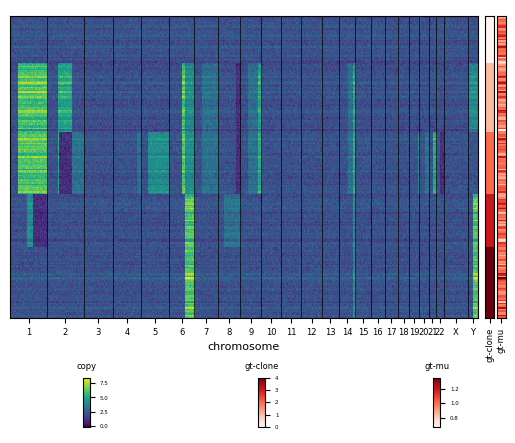

In [3]:
# simulate datasets
print("simulating dataset...")
config = Config(n_cells=N, n_nodes=K, n_states=A, chain_length=M, n_run_iter=n_iter, debug=True, step_size=0.08, wis_sample_size=50)
# for dsi in range(n_datasets):
fix_joint_q, sim_adata = simul.generate_dataset_var_tree(config, chrom='real', ret_anndata=True,
                                                         nu_prior=nu0, lambda_prior=lambda0, 
                                                         alpha_prior=alpha0, beta_prior=beta0,
                                                         eps_a=a0, eps_b=b0, dir_alpha=delta0)

sim_adata.obs['gt-clone'] = fix_joint_q.z.true_params['z'].numpy()
sim_adata.layers['state'] = fix_joint_q.c.true_params['c'].numpy()[sim_adata.obs['gt-clone']]
sim_adata.obs['gt-mu'] = fix_joint_q.mt.true_params['mu'].numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'copy', annotation_fields=['gt-clone', 'gt-mu'], cell_order_fields=['gt-clone'], raw=True)

Fig: simulated reads together with true clustering and baseline.

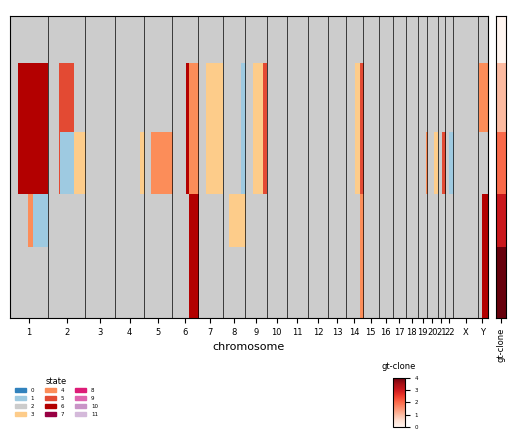

In [4]:
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'state', annotation_fields=['gt-clone'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

Fig. True copy number signal for each cluster.

In [5]:
# set up qmt, cell-qc
cell_config = Config(n_cells=N, n_nodes=N+1, n_states=A, n_run_iter=n_iter, step_size=0.2,
                     chain_length=config.chain_length, chromosome_indexes=config.chromosome_indexes, debug=True)
cell_qmt = qMuTau(cell_config, nu_prior=1., lambda_prior=1000., alpha_prior=50000., beta_prior=500.)
cell_qmt.initialize(method='prior')

cell_qc = qCMultiChrom(cell_config)
cell_qc.initialize(method='diploid')

cell_qeps = qEpsilonMulti(cell_config, alpha_prior=1., beta_prior=10.)
cell_qeps.initialize(method='fixed-equal', eps_alpha=cell_config.chain_length / 100, eps_beta=cell_config.chain_length)

In [6]:
# run inference with qmt,cell-qc
fixed_z = torch.arange(1, N + 1)
cell_qz_fix = qZ(cell_config, true_params={'z': fixed_z})
cell_tree = get_tree_K_nodes_one_level(N + 1)

print("running inference...")
for i in range(n_iter):
    cell_qmt.update(cell_qc, cell_qz_fix, fix_joint_q.obs)
    cell_qc.update(fix_joint_q.obs, cell_qeps, cell_qz_fix, cell_qmt,
                   [cell_tree], [1.])
    cell_qeps.update([cell_tree], torch.tensor([1.]), cell_qc)
    if (i+1) % 10 == 0:
        print(f"it {i}, elbo {cell_qc.compute_elbo([cell_tree], [1.], q_eps=cell_qeps)}")


running inference...
it 9, elbo -123100.24963378906
it 19, elbo -134006.71878051758
it 29, elbo -124768.13635253906
it 39, elbo -113791.27032470703


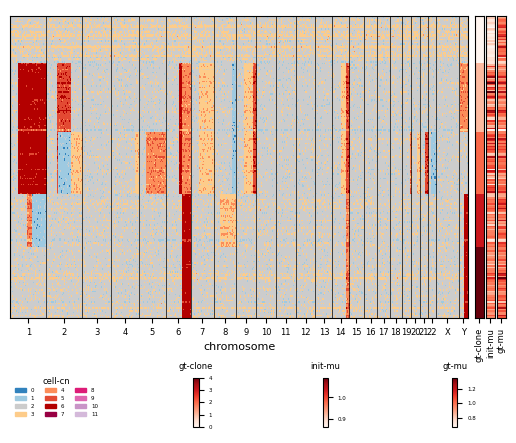

In [7]:
# after inference on cells specific cn
sim_adata.layers['cell-cn'] = cell_qc.get_viterbi()[1:].numpy()
sim_adata.obs['init-mu'] = cell_qmt.nu.numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'cell-cn', annotation_fields=['gt-clone', 'init-mu', 'gt-mu'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

Fig. Cell-specific copy number profile when qMuTau and cell-qC are jointly inferred for initialization

In [8]:
print("running k-means")
# cluster copy numbers with kmeans (on viterbi)
kmeans = KMeans(n_clusters=K, random_state=0).fit(cell_qc.get_viterbi()[1:])
c_labels = kmeans.labels_

print(f"ARI for KMeans after cell-cn estimation: {adjusted_rand_score(c_labels, fix_joint_q.z.true_params['z'].numpy())}")

# cluster copy numbers with kmeans (on viterbi)
obs_kmeans = KMeans(n_clusters=K, random_state=0).fit(fix_joint_q.obs.T.numpy())
obs_labels = obs_kmeans.labels_

print(f"ARI for KMeans with obs: {adjusted_rand_score(obs_labels, fix_joint_q.z.true_params['z'].numpy())}")


running k-means
ARI for KMeans after cell-cn estimation: 1.0
ARI for KMeans with obs: 0.7363641876702759


In [9]:
# initialize new qc with average
# build eta1 and eta2 from cell_qc
qc = qCMultiChrom(config)

for i, chr_qc in enumerate(qc.qC_list):
    # init for each chromosome the average tensor
    avg_param = {'eta1': torch.empty_like(chr_qc.eta1), 'eta2': torch.empty_like(chr_qc.eta2)}
    for k in range(K):
        cells_k = c_labels == k
        # average of eta parameters over cells assigned to the same cluster
        avg_param['eta1'][k, ...] = cell_qc.qC_list[i].eta1[1:][cells_k].mean(dim=0)
        avg_param['eta2'][k, ...] = cell_qc.qC_list[i].eta2[1:][cells_k].mean(dim=0)
    # normalization step
    avg_param['eta1'] = avg_param['eta1'] - torch.logsumexp(avg_param['eta1'], dim=-1, keepdim=True)
    avg_param['eta2'] = avg_param['eta2'] - torch.logsumexp(avg_param['eta2'], dim=-1, keepdim=True)

    chr_qc.initialize(method='fixed', **avg_param)

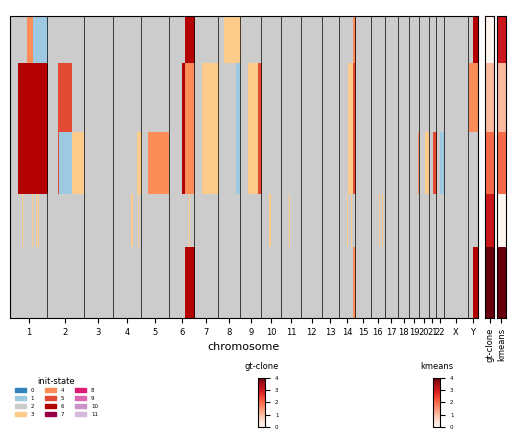

In [10]:
# inspect current state of new qC
sim_adata.layers['init-state'] = qc.get_viterbi().numpy()[sim_adata.obs['gt-clone']]
sim_adata.obs['kmeans'] = c_labels
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'init-state', annotation_fields=['gt-clone', 'kmeans'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

In [11]:
stable_zero = 1e-2
# initialize new qz (with current clustering) and new qeps
qz = qZ(config)
pi_init = torch.nn.functional.one_hot(torch.tensor(c_labels).long(), num_classes=config.n_nodes)
pi_init_smooth = torch.empty_like(pi_init, dtype=torch.float)
pi_init_smooth[pi_init == 1] = 1 - stable_zero
pi_init_smooth[pi_init == 0] = stable_zero / (config.n_nodes - 1)
# qz.initialize(z_init='fixed', pi_init=pi_init)
qz.initialize(z_init='fixed', pi_init=pi_init_smooth)

qpi = qPi(config)
cell_counts = np.unique(c_labels, return_counts=True)[1]
concentration_param_init = torch.tensor(cell_counts)
qpi.initialize(method='fixed', concentration_param_init=concentration_param_init)

qeps = qEpsilonMulti(config, alpha_prior=a0, beta_prior=b0)
qeps.initialize(method='prior')

qmt = qMuTau(config, nu_prior=1., lambda_prior=10., alpha_prior=50., beta_prior=5.)
qmt.initialize(method='fixed', loc=cell_qmt.nu, precision_factor=cell_qmt.lmbda, shape=cell_qmt.alpha, rate=cell_qmt.beta)

In [12]:
print("few more updates for qc and qmt after clustering...")
treeK = get_tree_K_nodes_one_level(config.n_nodes)

for i in range(50):
    qc.update(fix_joint_q.obs, qeps, qz, qmt, [treeK], [1.])
    qeps.update([treeK], [1.], qc)
    qmt.update(qc, qz, fix_joint_q.obs)

few more updates for qc and qmt after clustering...


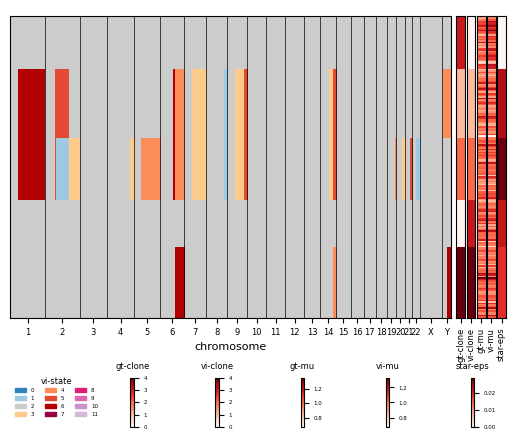

In [13]:
sim_adata.obs['vi-clone'] = qz.pi.argmax(dim=-1).numpy()
sim_adata.layers['vi-state'] = qc.get_viterbi().numpy()[sim_adata.obs['vi-clone']]
sim_adata.obs['vi-mu'] = qmt.nu.numpy()

# analyze eps
eps_mean_K = [qeps.mean()[0,k].item() for k in range(1, config.n_nodes)]
eps_mean_K = np.array([0.] + eps_mean_K)
sim_adata.obs['star-eps'] = eps_mean_K[sim_adata.obs['vi-clone']]

g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['gt-clone', 'vi-clone', 'gt-mu', 'vi-mu', 'star-eps'], cell_order_fields=['vi-clone'], max_cn=7)

In [14]:
print("running inference post init...")
joint = FixedTreeJointDist(config, qc, qz, qeps, qmt, qpi, treeK, fix_joint_q.obs)
for i in range(100):
    joint.update(it = i)
    if (i+1) % 10 == 0:
        print(f"it {i}, elbo {joint.elbo}")
        

running inference post init...
it 9, elbo -58767.046875
it 19, elbo -43934.54296875
it 29, elbo -39148.671875
it 39, elbo -37348.40625
it 49, elbo -36599.7734375
it 59, elbo -36284.4140625
it 69, elbo -36141.1328125
it 79, elbo -36042.26171875
it 89, elbo -35918.65234375
it 99, elbo -35824.13671875


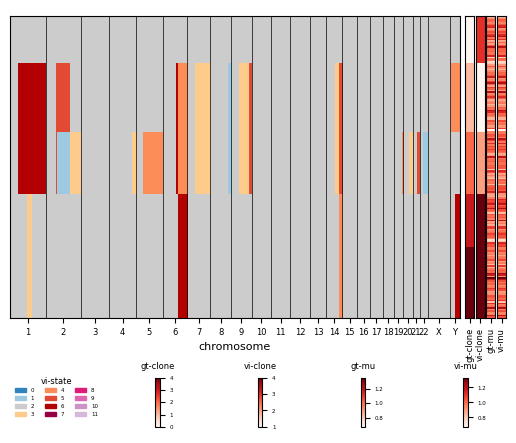

In [15]:
sim_adata.obs['vi-clone'] = qz.pi.argmax(dim=-1).numpy()
sim_adata.layers['vi-state'] = qc.get_viterbi().numpy()[sim_adata.obs['vi-clone']]
sim_adata.obs['vi-mu'] = qmt.nu.numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['gt-clone', 'vi-clone', 'gt-mu', 'vi-mu'], cell_order_fields=['gt-clone'], max_cn=7)

## ISSUE

No cells are assigned to the healthy clone, and similar clusters are confounded.
When running qMuTau and cell-qC jointly in the beginning, it's easy for the algorithm
to find optima in mu that are smaller/larger than the true mu, while offsetting the
copy number accordingly. This can be avoided by using HMMcopy profile instead as an
initialization step.

## attempts

- initializing epsilon to low values slows down convergence: due to small step-size
  it takes time for eps_a and eps_b to reach stable values which scale with M.
  *Sol*: initialize to larger values using M as scale
- qc also should not be randomly initialized because that will drive the epsilon
  parameters to values for which the mean is large (around 0.5) in the first inference steps
  
## one solution
Initializing the copy number profiles to (smoothed) diploid profile helps in avoiding
the initial drift to wrong eps params!
initializing qC to random or even uniform markov transitions is a really bad initialization,
because it will drive epsilon to reach larger values due to the enormous number of copy 
number changes. This leads to the first inference step where epsilon goes up until when 
it stabilizes and then the copy numbers will decrease the number of changes by following
the data and so epsilon will slowly drop again.

## Tree inference
We now inspect the resulting epsilon values and from those, we try to infer the tree

In [16]:
from variational_distributions.var_dists import qT
from variational_distributions.joint_dists import VarTreeJointDist

qt = qT(config)
qt.initialize()

print("updating qt and qeps jointly")
for i in range(30):
    qt.update(qc, qeps)
    tlist, wtens = qt.get_trees_sample()
    qeps.update(tlist, wtens, qc)
    if i % 5 == 0:
        print(f"it: {i}, qt elbo: {qt.compute_elbo()}")
    

updating qt and qeps jointly
it: 0, qt elbo: -2.0656681060791016
it: 5, qt elbo: -2.425461769104004
it: 10, qt elbo: -2.8895788192749023
it: 15, qt elbo: -3.340754985809326
it: 20, qt elbo: -3.595175266265869
it: 25, qt elbo: -3.799564838409424


In [17]:
full_q = VarTreeJointDist(config, fix_joint_q.obs, qc, qz, qeps=qeps, qmt=qmt, qpi=qpi,
                          qt=qt)

for i in range(100):
    full_q.update()
    if i % 5 == 0:
        print(f"it: {i}, qt elbo: {full_q.compute_elbo()}")


it: 0, qt elbo: -37475.1953125
it: 5, qt elbo: -37443.7578125
it: 10, qt elbo: -37432.75
it: 15, qt elbo: -37422.72265625
it: 20, qt elbo: -37426.828125
it: 25, qt elbo: -37422.26171875
it: 30, qt elbo: -37417.90625
it: 35, qt elbo: -37415.73046875
it: 40, qt elbo: -37403.2890625
it: 45, qt elbo: -37410.3671875
it: 50, qt elbo: -37414.421875
it: 55, qt elbo: -37410.03515625
it: 60, qt elbo: -37403.72265625
it: 65, qt elbo: -37415.24609375
it: 70, qt elbo: -37402.015625
it: 75, qt elbo: -37402.296875
it: 80, qt elbo: -37407.41796875
it: 85, qt elbo: -37409.33203125
it: 90, qt elbo: -37411.70703125
it: 95, qt elbo: -37405.27734375


In [18]:
from utils.evaluation import best_mapping
import networkx as nx

# remap clones
mapping = best_mapping(gt_z=fix_joint_q.z.true_params['z'].numpy(), vi_z=full_q.z.pi.numpy())

remapped_true_tree = nx.relabel_nodes(fix_joint_q.t.true_params['tree'], {a: b for a, b in enumerate(mapping)})


In [19]:
qt_dict = full_q.t.get_pmf_estimate(normalized=True, desc_sorted=True, n=500)
true_nwk = tree_to_newick(remapped_true_tree) 
print(f"true tree: {true_nwk}, p: {qt_dict[true_nwk]}")

print("tree dist")
for t, p in qt_dict.items():
    print(t)
    print(p)
    print("-----")

true tree: (((2)1,3)4)0, p: 0.008768982253968716
tree dist
((((4)3)1)2)0
tensor(0.0198)
-----
((((2)4)3)1)0
tensor(0.0183)
-----
(2,((1)4)3)0
tensor(0.0170)
-----
(((3)1,2)4)0
tensor(0.0166)
-----
(1,((4)2)3)0
tensor(0.0160)
-----
((((3)4)1)2)0
tensor(0.0159)
-----
((1,(3)4)2)0
tensor(0.0154)
-----
((((1)4)3)2)0
tensor(0.0153)
-----
((((1)3)4)2)0
tensor(0.0152)
-----
((((1)2)3)4)0
tensor(0.0152)
-----
((((2)3)4)1)0
tensor(0.0145)
-----
((((3)4)2)1)0
tensor(0.0141)
-----
((1,(2)3)4)0
tensor(0.0134)
-----
((((4)2)1)3)0
tensor(0.0131)
-----
(((1,3)4)2)0
tensor(0.0128)
-----
(((4)2,3)1)0
tensor(0.0126)
-----
((1,(2)4)3)0
tensor(0.0126)
-----
(1,(2,4)3)0
tensor(0.0125)
-----
(((4)3)1,2)0
tensor(0.0123)
-----
(((4)1,2)3)0
tensor(0.0122)
-----
(2,(1,4)3)0
tensor(0.0120)
-----
(2,(1,3)4)0
tensor(0.0120)
-----
((((4)3)2)1)0
tensor(0.0120)
-----
((1,4)2,3)0
tensor(0.0118)
-----
((((2)1)3)4)0
tensor(0.0116)
-----
(2,((3)1)4)0
tensor(0.0114)
-----
((1,2,4)3)0
tensor(0.0114)
-----
((((2)4)1)3)0
ten

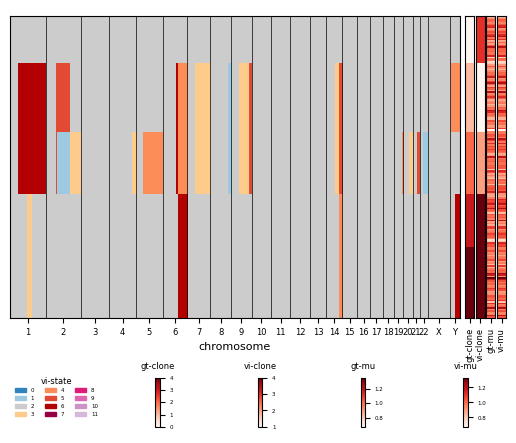

In [20]:
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['gt-clone', 'vi-clone', 'gt-mu', 'vi-mu'], cell_order_fields=['gt-clone'], max_cn=7)

## Final considerations

The tree still is not correctly estimated and definitely not certain enough on a small set of topologies.
The probability mass is spread over many topologies making downstream tree-reconstruction task difficult.

After the last updates, two (similar) clones are also merged together.
This may suggest few things:
- qt was not updated long enough while qc and qz are fixed, resulting in an uncertain qt which then
destabilize the already good copy number signal and clone assignment
- qt needs a better initialization possibly coming from the epsilon values that were already
inferred in the previous update steps
- a different step size for the final update could work better